In [1]:
%matplotlib widget
import argparse
import gc
import random
import torch
from PIL import Image
from torchvision.transforms import PILToTensor
from src.feature_extractor import CDHFExtractor
from src.visualization import Demo
from src.pipe_utils import pipe_selector
from src.new_resnet import set_timestep, init_resnet_func
from omegaconf import OmegaConf

In [2]:
torch.cuda.set_device(0)

In [18]:
LCM_MODELS_DICT = { 1: "LCM_Dreamshaper_v7",
                    2: "lcm-lora-sdv1-5", 
                    3: "lcm-sdxl", 
                    4: "lcm-ssd-1b", 
                    5: "lcm-lora-sdxl", 
                    6: "lcm-lora-ssd-1b",
                    }
config_path = "/home/zzw5373/wh/ConsistentDiffusionHyperfeatures/configs/train.yaml"
config = OmegaConf.load(config_path)
config = OmegaConf.to_container(config, resolve=True)
lcm_model_name = LCM_MODELS_DICT[1]
image_path = "/home/zzw5373/wh/ConsistentDiffusionHyperfeatures/img/cute_pig.png"
num_inference_steps = 50
prompt = ""
save_timestep = [49]
device = "cuda"

seed = 10006
torch.manual_seed(seed)

pipe_dict = pipe_selector(lcm_model_name)
# cdhf_extractor = CDHFExtractor(config, pipe_dict, use_xformers=True)
cdhf_extractor = CDHFExtractor(config, pipe_dict)
# cdhf_extractor.one_step_image_restoration(image_path=image_path, num_inference_steps=num_inference_steps, prompt = prompt)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/zzw5373/miniconda3/envs/cdhf/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py:761: FutureWarning: `torch_dtype` is deprecated and will be removed in version 0.25.0. 
  deprecate("torch_dtype", "0.25.0", "")
/home/zzw5373/miniconda3/envs/cdhf/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py:764: FutureWarning: `torch_device` is deprecated and will be removed in version 0.25.0. 
  deprecate("torch_device", "0.25.0", "")


torch.Size([1, 1280, 32, 32])
torch.Size([1, 1280, 32, 32])


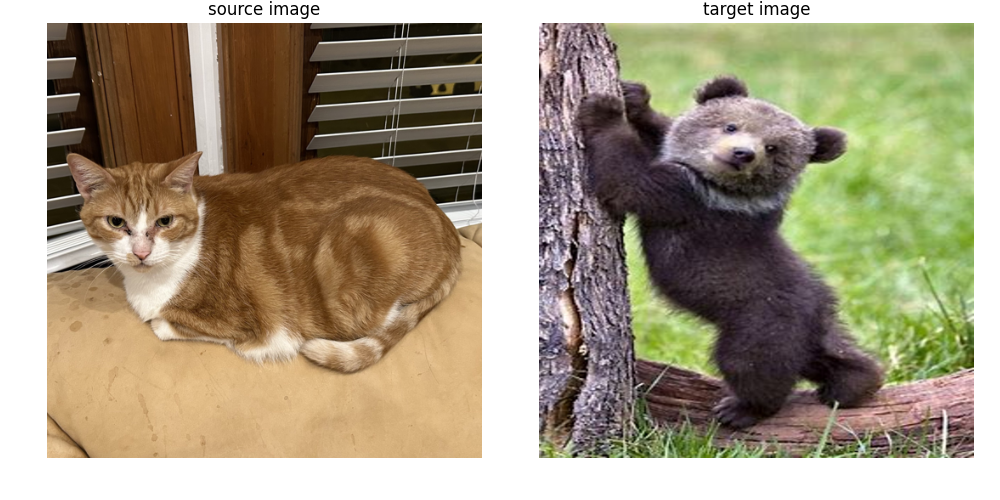

In [19]:
ft = []
imglist = []

# decrease these two if you don't have enough RAM or GPU memory
img_size = 512
# ensemble_size = 8

filelist = ["/home/zzw5373/wh/ConsistentDiffusionHyperfeatures/img/feature/ref_img.jpg", "/home/zzw5373/wh/ConsistentDiffusionHyperfeatures/img/feature/ref_bear_img.jpg"]
# filelist = ["./img/feature/ref_car.jpg", "./img/feature/tar_car.jpg"]
save_path = "./img/demo/"

for i, filename in enumerate(filelist):
    unet_layers_t_list = []
    img = Image.open(filename).convert('RGB')
    img = img.resize((img_size, img_size))
    imglist.append(img)

    estimate_mode = 1

    if estimate_mode == 1:
        #################### 1 (independent one step generation) ################################################
        # t_id_list = [30]  # 36 is the best!
        # t_id_list = [30, 35, 40, 45, 49]
        # t_id_list = [30, 35, 40, 45, 49]
        t_id_list = [40]
        init_resnet_func(cdhf_extractor.pipe.unet, save_hidden=True, reset=True, idxs=cdhf_extractor.idxs, save_timestep=t_id_list)
        for t_id in t_id_list:
            unet_layers_t = cdhf_extractor.extract_features(filename, t_id)[1] # 1 is the best!
            unet_layers_t_list.append(unet_layers_t)

        unet_layers_t = torch.mean(torch.stack(unet_layers_t_list), dim=0)
        print(unet_layers_t.shape)


        feats = []
        for timestep in t_id_list:
            timestep_feats = cdhf_extractor.collect_and_resize_feats(cdhf_extractor.pipe.unet, cdhf_extractor.idxs, timestep, cdhf_extractor.output_resolution)
            feats.append(timestep_feats)
        feats = torch.stack(feats, dim=1)
        # unet_layers_t = feats[:,0,6000:8000,:,:]
        # unet_layers_t = feats[:,0,3840:5120,:,:] # layer 4
        # unet_layers_t = feats[:,0,5120:6400,:,:] # layer 5
        unet_layers_t = feats[:,0,6400:7680,:,:] # layer 6

    elif estimate_mode == 2:
        #################### 2 (4 step chain generation) #######################################################
        # new_timesteps = [399, 339, 279, 199, 159, 59, 19]
        # new_timesteps = [339, 279, 199, 19]
        # new_timesteps = [279, 199, 19]
        # choise 719, 699, 679, 659, 639, 619, 599, 579, 559, 539, 519, 499, 479, 459, 439, 419, 399, 379, 359, 339, 319, 299, 279, 259, 239, 219, 199, 179,
        # new_timesteps = [639, 499, 399, 199, 19]
        # new_timesteps = [499, 399, 199, 19]
        new_timesteps = [439, 399, 199, 19]
        unet_layers_list, x_0_predicted  = cdhf_extractor.extract_features_generation(filename, new_timesteps)
        unet_layer_mean_list = []
        for layer_list in unet_layers_list:
            unet_layer_mean = torch.mean(torch.stack(layer_list), dim=0)
            unet_layer_mean_list.append(unet_layer_mean)
        unet_layers_t = unet_layer_mean_list[1]
        unet_layers_t = unet_layers_list[1][0] # maybe [1][1] is the best
        # unet_layers_t = torch.mean(torch.stack([unet_layers_list[1][0], unet_layers_list[1][1]]), dim=0)
        output_latent = cdhf_extractor.pipe.vae.decode(x_0_predicted / cdhf_extractor.pipe.vae.config.scaling_factor, return_dict=False)[0].detach().clone()
        images = cdhf_extractor.pipe.image_processor.postprocess(output_latent, output_type="pil")
        images[0].save(f"{save_path}x_0_predicted_{i}.png")

    ft.append(unet_layers_t)

ft = torch.cat(ft, dim=0)
gc.collect()
torch.cuda.empty_cache()
demo = Demo(imglist, ft, img_size)
demo.plot_img_pairs(fig_size=5)

In [22]:
import os

additional_embeds = cdhf_extractor.pipe.encode_prompt(prompt=prompt,device=device,num_images_per_prompt=1,do_classifier_free_guidance=False)

timesteps = cdhf_extractor.pipe.scheduler.timesteps

image_path = "/home/zzw5373/wh/ConsistentDiffusionHyperfeatures/img/feature/ref_img.jpg"

image_tensors = cdhf_extractor.image2tensor(image_path) # image_tensor shape [1, 3, 512, 512]
# img_latent = cdhf_extractor.pipe.vae.encode(image_tensors).latent_dist.sample(generator=generator) * cdhf_extractor.pipe.vae.config.scaling_factor # img_latent shape [1, 4, 64, 64]
img_latent = cdhf_extractor.pipe.vae.encode(image_tensors).latent_dist.sample(generator=None) * cdhf_extractor.pipe.vae.config.scaling_factor # img_latent shape [1, 4, 64, 64]

timesteps = cdhf_extractor.pipe.scheduler.timesteps

print("t", t_id_list)
t = timesteps[t_id_list[0]]
sampled_noise = torch.randn_like(img_latent).to(device)

x_t_latent = cdhf_extractor.pipe.scheduler.add_noise(img_latent, sampled_noise, t) # we can only add noise in the latent space
# x_t_latent = img_latent

output = cdhf_extractor.pipe.lcm_generation_one_step(x_t_latent, t, -1, additional_embeds=additional_embeds)
# x_t_latent = output["x_t_next_latent"]
x_t_next_latent = output["x_t_next_latent"]
x_0_predicted = output["x_0_predicted_latent"]

output_latent = x_0_predicted
output_latent = cdhf_extractor.pipe.vae.decode(output_latent / cdhf_extractor.pipe.vae.config.scaling_factor, return_dict=False)[0].detach().clone()

x_t_next_output = x_t_next_latent
x_t_next_output = cdhf_extractor.pipe.vae.decode(x_t_next_output / cdhf_extractor.pipe.vae.config.scaling_factor, return_dict=False)[0].detach().clone()

# Postprocess image
images = cdhf_extractor.pipe.image_processor.postprocess(output_latent, output_type="pil")
x_t_next_images = cdhf_extractor.pipe.image_processor.postprocess(x_t_next_output, output_type="pil")

if not os.path.exists(f"./img/generate/ref_bear/no_iterate_x0_generate/seed_{seed}"):
    os.makedirs(f"./img/generate/ref_bear/no_iterate_x0_generate/seed_{seed}")
images[0].save(f"./img/generate/ref_bear/no_iterate_x0_generate/seed_{seed}/no_iterate_x0_generate_timestep{t}.png")

if not os.path.exists(f"./img/generate/ref_bear/no_iterate_xt_next_generate/seed_{seed}"):
    os.makedirs(f"./img/generate/ref_bear/no_iterate_xt_next_generate/seed_{seed}")
x_t_next_images[0].save(f"./img/generate/ref_bear/no_iterate_xt_next_generate/seed_{seed}/no_iterate_xt_next_generate_timestep{t}.png")



t [40]
